In [1]:
%cd drive/MyDrive/Colab\ Notebooks/step-counts-prediction

/content/drive/MyDrive/Colab Notebooks/step-counts-prediction


In [2]:
import pandas as pd
import numpy as np
import yaml
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from utils.preprocessing import aggregate_steps, augment, to_supervised
from utils.postprocessing import from_supervised, hours_to_date
from models import naive, average_by_dow, preceding_average
from models import simple_RNN, LSTM_model, GRU_model, BLSTM_model
from models import create_models

from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

# Data preprocessing

### Load the data

In [3]:
# Load the data
PATH = 'data/StepCount.csv'
data = pd.read_csv(PATH)

# Load config file
with open("config.yml", 'r') as handle:
    config = yaml.safe_load(handle)

### Aggregate the raw sequence by date and by date and hour

In [4]:
# Create 3 datasets
steps_date = aggregate_steps(data, ['date'])
date_dow = steps_date[['date', 'dow']]
steps_date = steps_date.value

steps_hour = aggregate_steps(data, ['date', 'hour'])
date_hour = steps_hour[['date', 'hour']]
steps_hour = steps_hour.value

augmented_steps_date = augment(data)

print(steps_date.shape)
print(steps_hour.shape)
print(augmented_steps_date.shape)

(1671,)
(20334,)
(1671, 7)


# Data exploration

### Box plot

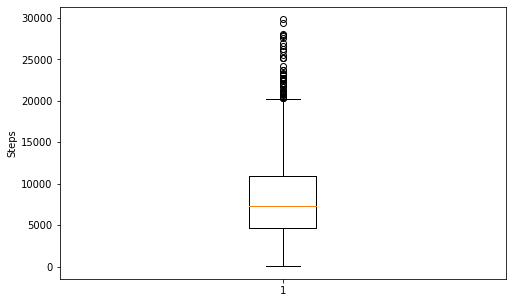

In [13]:
plt.figure(figsize=(8, 5))
plt.boxplot(steps_date)
plt.ylabel("Steps")
plt.savefig("img/outliers.pdf", format="pdf", dpi=1200)

### Distribution of the steps/date data

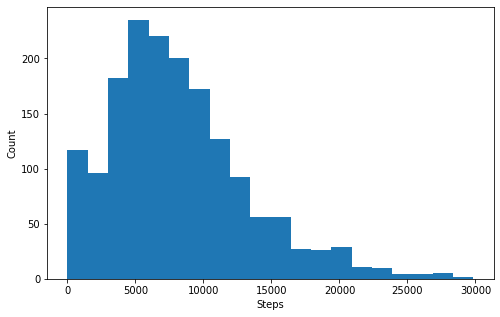

In [15]:
steps_date.hist(figsize=(8, 5), bins=20, grid=False)
plt.ylabel("Count")
plt.xlabel("Steps")
plt.savefig("img/distribution.pdf", format="pdf", dpi=1200)

### Impute values lower than 300 steps per day with a median

In [5]:
# Count the number of entries with SC < 300
print("The number of removed outliers:", len(steps_date[steps_date < 300]))
print("The percentage of removed outliers: {:.3f}%".format(len(steps_date[steps_date < 300])/len(steps_date)*100))

# Replace steps < 300 with a median value
median = steps_date.median()
steps_date[steps_date < 300] = median
augmented_steps_date.value[augmented_steps_date.value < 300] = median

The number of removed outliers: 30
The percentage of removed outliers: 1.795%


### Plot the augmented steps/date features

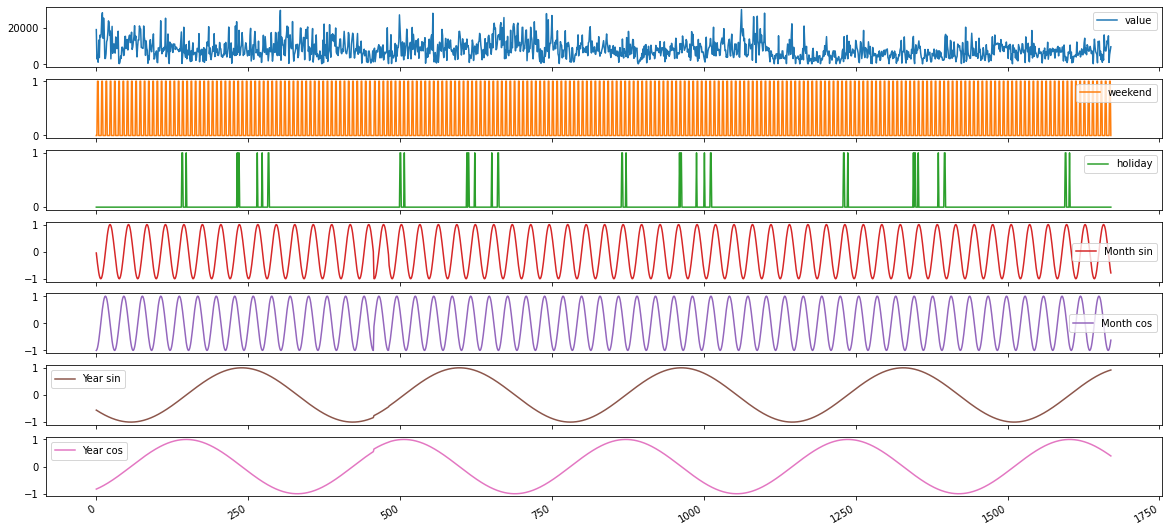

In [10]:
aug_data_fig = augmented_steps_date.plot(subplots=True, figsize=(20, 10))
plt.savefig("img/aug_data.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

# Training

In [8]:
EPOCHS = 1000
early_stopping = EarlyStopping(
    'val_mean_absolute_error', 0.000001, 5, restore_best_weights=True)

# Fit the scaler on the training data for a later use
global_scaler = MinMaxScaler()
train_size = int(len(steps_date)*0.8)
global_scaler.fit(steps_date.iloc[:train_size].to_numpy().reshape(-1, 1))

MinMaxScaler()

# Baselines

### Prepare the data for baseline models

In [6]:
baseline_model = create_models(config, "steps_date", steps_date, ["Baseline"])
current = baseline_model['Baseline_steps_date']
X_train, y_train, X_val, y_val, X_test, y_test = current.get_data()

## Naive baseline predictions

In [10]:
# Predict
naive_predictions = naive(X_test, 1)

# Evaluate
naive_mae = mean_absolute_error(y_test, naive_predictions)
naive_error_steps = int(global_scaler.inverse_transform(np.array(naive_mae).reshape(1, -1))[0][0])
naive_rmse = sqrt(mean_squared_error(y_test, naive_predictions))

print("MAE: {:.4f}".format(naive_mae))
print("MAE (steps):", naive_error_steps)

MAE: 0.1151
MAE (steps): 3698


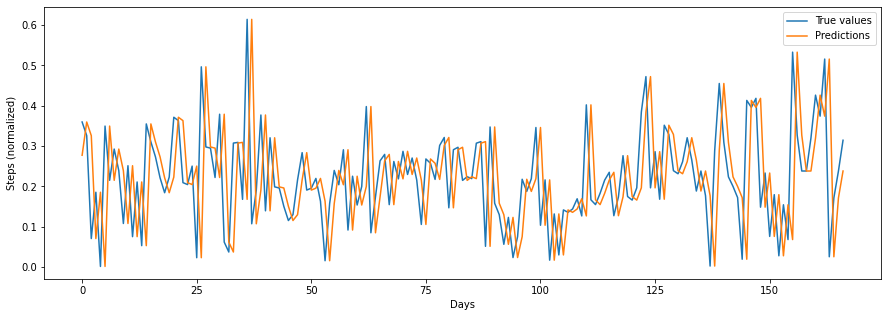

In [75]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label="True values")
plt.plot(naive_predictions, label="Predictions")
#plt.title("Naive forecast")
plt.ylabel("Steps (normalized)")
plt.xlabel("Days")
plt.legend()
plt.savefig("img/naive.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

## Day of the week average predictions

In [11]:
future = current.future
lag = current.lag

# Predict
history = np.concatenate([X_train.squeeze(), X_val.squeeze()])
av_predictions = []
for i in range(len(y_test)):
    av_predictions.append(average_by_dow(history, date_dow, 1))
    history = np.append(history, y_test[i])

# Evaluate
average_by_dow_mae = mean_absolute_error(y_test, av_predictions)
average_by_dow_error_steps = int(global_scaler.inverse_transform(np.array(average_by_dow_mae).reshape(1, -1))[0][0])
average_by_dow_rmse = sqrt(mean_squared_error(y_test, av_predictions))

print("MAE: {:.4f}".format(average_by_dow_mae))
print("MAE (steps):", average_by_dow_error_steps)

MAE: 0.1019
MAE (steps): 3310


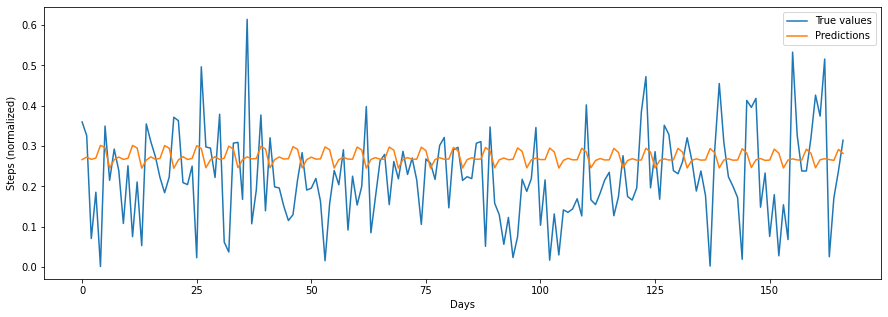

In [77]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label="True values")
plt.plot(av_predictions, label="Predictions")
#plt.title("Average of the day of the week")
plt.ylabel("Steps (normalized)")
plt.xlabel("Days")
plt.legend()
plt.savefig("img/av.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

## Previous 7 days average predictions

MAE: 0.0893
MAE (steps): 2938


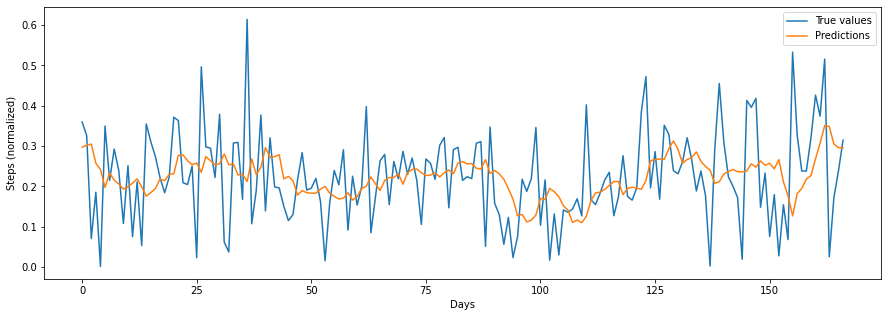

In [12]:
# Predict
history = np.concatenate([X_train.squeeze(), X_val.squeeze()])
av2_predictions = []
for i in range(len(y_test)):
    av2_predictions.append(preceding_average(history, 7))
    history = np.append(history, y_test[i])

# Evaluate
preceding_average_mae = mean_absolute_error(y_test, av2_predictions)
preceding_average_error_steps = int(global_scaler.inverse_transform(np.array(preceding_average_mae).reshape(1, -1))[0][0])
preceding_average_rmse = sqrt(mean_squared_error(y_test, av2_predictions))

print("MAE: {:.4f}".format(preceding_average_mae))
print("MAE (steps):", preceding_average_error_steps)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(y_test, label="True values")
plt.plot(av2_predictions, label="Predictions")
#plt.title(f"Average of the previous 7 days")
plt.ylabel("Steps (normalized)")
plt.xlabel("Days")
plt.legend()
plt.savefig("img/av2.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

# Experiment 1

Steps/Date dataset

In [81]:
# Create a DataFrame with results
row = 0
results_date = pd.DataFrame(columns=["Model", "Lag", "MAE", "RMSE", "Error_Steps"])

In [82]:
# Prepare data for all models with the steps/date dataset
steps_date_models = create_models(config, "steps_date", steps_date)

# Train models
for i in steps_date_models:
    current = steps_date_models[i]

    if current.model_type in ["RNN", "LSTM", "BLSTM", "GRU"]:
        units = current.hyperparams['units']
        n_hidden = current.hyperparams['n_hidden']
        lr = current.hyperparams['lr']
        m_batch_size = current.hyperparams['m_batch_size']
        X_train, y_train, X_val, y_val, X_test, y_test = current.get_data()
        n_timestamps = X_train.shape[1]
        n_features = X_train.shape[2]
        next_predicted = current.future

        if i.startswith("LSTM"):
            model = LSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("RNN"):
            model = simple_RNN(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("BLSTM"):
            model = BLSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("GRU"):
            model = GRU_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)

        # Pre-train without early stopping
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=8,
            batch_size=m_batch_size
            )
        # Train with early stopping
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=EPOCHS,
            batch_size=m_batch_size,
            verbose=1,
            callbacks=[early_stopping]
            )

        clear_output()
        model.save("models/"+i+".h5")

        # Predict
        y_pred = model.predict(X_test).squeeze()
        steps_date_models[i].predictions = y_pred

        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        error_steps = int(current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
        rmse = sqrt(mean_squared_error(y_test, y_pred))

        results_date.loc[row] = [
                            current.name, current.lag,
                            round(mae, 4),
                            round(rmse, 4),
                            error_steps]
        row += 1

In [83]:
results_date

,Model,Lag,MAE,RMSE,Error_Steps
0,RNN_7_1,7,0.0867,0.1141,2861
1,LSTM_7_1,7,0.0853,0.1134,2820
2,BLSTM_7_1,7,0.0861,0.1152,2844
3,GRU_7_1,7,0.0877,0.1156,2890
4,RNN_14_1,14,0.0881,0.1159,2901
5,LSTM_14_1,14,0.0864,0.1151,2850
6,BLSTM_14_1,14,0.0875,0.1173,2885
7,GRU_14_1,14,0.0881,0.1161,2901
8,RNN_21_1,21,0.0894,0.1180,2939
9,LSTM_21_1,21,0.0872,0.1154,2875


In [84]:
results_date.sort_values("MAE")

,Model,Lag,MAE,RMSE,Error_Steps
1,LSTM_7_1,7,0.0853,0.1134,2820
2,BLSTM_7_1,7,0.0861,0.1152,2844
5,LSTM_14_1,14,0.0864,0.1151,2850
0,RNN_7_1,7,0.0867,0.1141,2861
11,GRU_21_1,21,0.0870,0.1152,2871
9,LSTM_21_1,21,0.0872,0.1154,2875
6,BLSTM_14_1,14,0.0875,0.1173,2885
3,GRU_7_1,7,0.0877,0.1156,2890
4,RNN_14_1,14,0.0881,0.1159,2901
7,GRU_14_1,14,0.0881,0.1161,2901


### Plot predictions of the best model in this experiment on the test set

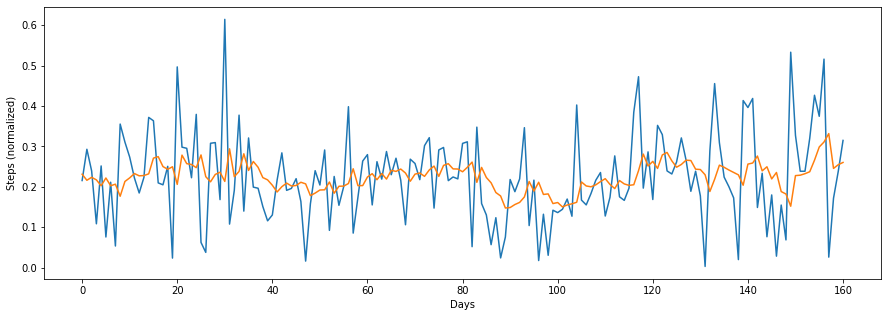

In [85]:
# Plot the bet prediction
model_name = results_date[results_date.MAE == results_date.MAE.min()].Model.iloc[0]

plt.figure(figsize=(15, 5))
plt.plot(steps_date_models[model_name].y_test, label="True values")
plt.plot(steps_date_models[model_name].predictions, label="Predictions")
#plt.title(model_name + " prediction")
plt.ylabel("Steps (normalized)")
plt.xlabel("Days")
plt.savefig("img/ex1_best_model.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Plot the MAE of all models grouped by time lag

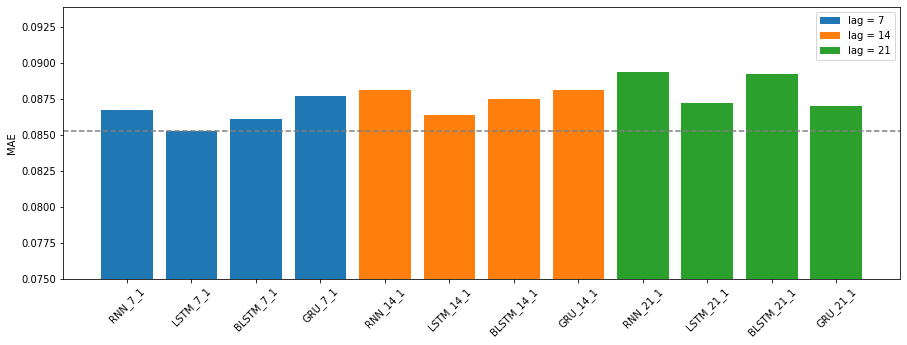

In [86]:
fig = plt.figure(figsize=(15, 5))
x = np.arange(len(results_date.MAE))
plt.bar(x[:4], results_date.MAE[results_date.Lag == 7], label="lag = 7")
plt.bar(x[4:8], results_date.MAE[results_date.Lag == 14], label="lag = 14")
plt.bar(x[8:12], results_date.MAE[results_date.Lag == 21], label="lag = 21")
plt.xticks(ticks=x, labels=results_date.Model,
           rotation=45)
plt.axhline(results_date.MAE.min(), color='grey', linestyle='dashed')
plt.ylabel("MAE")
plt.ylim(bottom=0.075)
plt.legend()
plt.savefig("img/ex1.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Average MAE of models per time lag

In [99]:
# Average MAE by time lag
results_date.groupby("Lag")['MAE'].mean()

Lag
7     0.086450
14    0.087525
21    0.088200
Name: MAE, dtype: float64

# Experiment 2
Steps/Hour dataset

In [22]:
# Create a DataFrame with results
row = 0
results_hour_to_date = pd.DataFrame(columns=["Model", "Lag", "MAE", "RMSE", "Error_Steps"])

for_plot = []

In [23]:
# Prepare data for all models with the steps/hour dataset
steps_hour_models = create_models(config, "steps_hour", steps_hour)

# Train the models
for i in steps_hour_models:
    current = steps_hour_models[i]

    if current.model_type in ["RNN", "LSTM", "BLSTM", "GRU"]:
        units = current.hyperparams['units']
        n_hidden = current.hyperparams['n_hidden']
        lr = current.hyperparams['lr']
        m_batch_size = current.hyperparams['m_batch_size']
        X_train, y_train, X_val, y_val, X_test, y_test = current.get_data()
        n_timestamps = X_train.shape[1]
        n_features = X_train.shape[2]
        next_predicted = current.future

        if i.startswith("LSTM"):
            model = LSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("RNN"):
            model = simple_RNN(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("BLSTM"):
            model = BLSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("GRU"):
            model = GRU_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)

        # Pre-train without early stopping
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=8,
            batch_size=m_batch_size
            )
        # Train with early stopping
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=EPOCHS,
            batch_size=m_batch_size,
            verbose=1,
            callbacks=[early_stopping]
            )

        clear_output()
        model.save("models/"+i+".h5")

        # Predict
        y_pred = model.predict(X_test).squeeze()
        steps_hour_models[i].predictions = y_pred

        # Transform supervised sequence to unsupervised one
        unsupervised_pred = from_supervised(y_pred)
        unsupervised_pred_size = len(unsupervised_pred)
        unnormalized_pred = current.scaler.inverse_transform(np.array(unsupervised_pred).reshape(1, -1)).squeeze()

        # Select dates that match the sequence
        pred_dates = date_hour.iloc[-unsupervised_pred_size:].reset_index(drop=True)

        # Transorm steps/hour to steps/date
        pred_by_date = hours_to_date(pd.DataFrame(unnormalized_pred, columns=["value"]), pred_dates)
        pred_by_date_size = len(pred_by_date)

        # Select ground truth values from the dataset
        real = steps_date.tail(pred_by_date_size)

        # Normalize the predictions and the true values to compute the error
        transformed_real = global_scaler.transform(real.to_numpy().reshape(-1, 1))
        transformed_pred = global_scaler.transform(pred_by_date.to_numpy().reshape(-1, 1))

        # Evaluate
        mae_date = mean_absolute_error(transformed_real, transformed_pred)
        mae_date_steps = int(global_scaler.inverse_transform(np.array(mae_date).reshape(1, -1))[0][0])
        rmse_date = sqrt(mean_squared_error(transformed_real, transformed_pred))

        # Save the transformed values for plotting
        for_plot.append([real, pred_by_date])

        results_hour_to_date.loc[row] = [
                        current.name, current.lag,
                        round(mae_date, 4),
                        round(rmse_date, 4),
                        mae_date_steps]
        row += 1

In [24]:
results_hour_to_date

,Model,Lag,MAE,RMSE,Error_Steps
0,RNN_24_24,24,0.1592,0.1865,5003
1,LSTM_24_24,24,0.0848,0.1060,2804
2,BLSTM_24_24,24,0.0899,0.1123,2956
3,GRU_24_24,24,0.0852,0.1063,2816
4,RNN_48_24,48,0.1512,0.1793,4766
5,LSTM_48_24,48,0.0852,0.1094,2815
6,BLSTM_48_24,48,0.0894,0.1139,2941
7,GRU_48_24,48,0.0858,0.1103,2834
8,RNN_72_24,72,0.1315,0.1579,4183
9,LSTM_72_24,72,0.0852,0.1070,2816


In [25]:
results_hour_to_date.sort_values("MAE")

,Model,Lag,MAE,RMSE,Error_Steps
11,GRU_72_24,72,0.0836,0.1054,2769
1,LSTM_24_24,24,0.0848,0.1060,2804
3,GRU_24_24,24,0.0852,0.1063,2816
5,LSTM_48_24,48,0.0852,0.1094,2815
9,LSTM_72_24,72,0.0852,0.1070,2816
7,GRU_48_24,48,0.0858,0.1103,2834
6,BLSTM_48_24,48,0.0894,0.1139,2941
10,BLSTM_72_24,72,0.0896,0.1124,2946
2,BLSTM_24_24,24,0.0899,0.1123,2956
8,RNN_72_24,72,0.1315,0.1579,4183


### Plot the predictions of the best model in the experiment on the test set

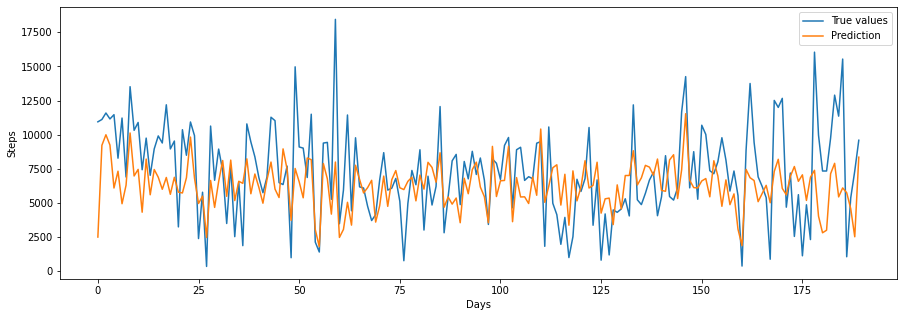

In [69]:
# Plot the best prediction
idx = results_hour_to_date[results_hour_to_date.MAE == results_hour_to_date.MAE.min()].index[0]
plt.figure(figsize=(15, 5))
plt.plot(for_plot[idx][0].reset_index(drop=True), label="True values")
plt.plot(for_plot[idx][1], label="Prediction")
#plt.title(results_hour_to_date.loc[idx].Model + " prediction")
plt.ylabel("Steps")
plt.xlabel("Days")
plt.legend()
plt.savefig("img/ex2_best_model.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Plot the MAE of all models grouped by time lag

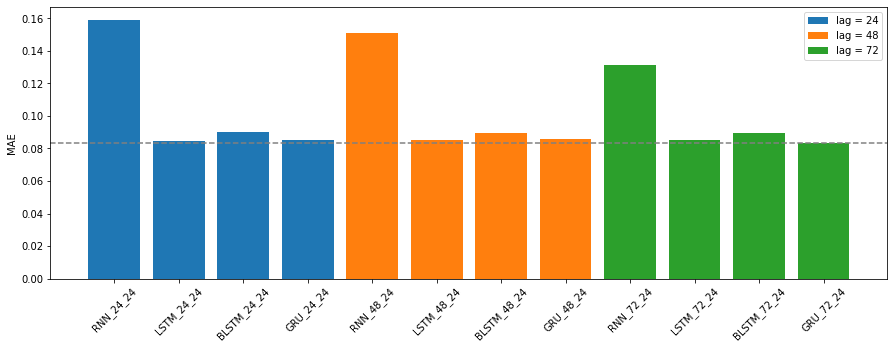

In [68]:
fig = plt.figure(figsize=(15, 5))
x = np.arange(len(results_hour_to_date.MAE))
plt.bar(x[:4], results_hour_to_date.MAE[results_hour_to_date.Lag == 24], label="lag = 24")
plt.bar(x[4:8], results_hour_to_date.MAE[results_hour_to_date.Lag == 48], label="lag = 48")
plt.bar(x[8:12], results_hour_to_date.MAE[results_hour_to_date.Lag == 72], label="lag = 72")
plt.xticks(ticks=x, labels=results_hour_to_date.Model,
           rotation=45)
plt.axhline(results_hour_to_date.MAE.min(), color='grey', linestyle='dashed')
plt.ylabel("MAE")
plt.legend()
plt.savefig("img/ex2.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Average MAE of the models per time lag

In [100]:
# Average MAE by time lag
results_hour_to_date.groupby("Lag")['MAE'].mean()

Lag
24    0.104775
48    0.102900
72    0.097475
Name: MAE, dtype: float64

# Experiment 3
Augmented steps/date dataset

In [33]:
# Create a DataFrame with results
row = 0
results_augmented_date = pd.DataFrame(columns=["Model", "Lag", "MAE", "RMSE", "Error_Steps"])

In [34]:
# Prepare data for all models with the augmented steps/date dataset
aug_steps_date_models = create_models(config, "augmented_steps_date", augmented_steps_date)

# Train the models
for i in aug_steps_date_models:
    current = aug_steps_date_models[i]

    if current.model_type in ["RNN", "LSTM", "BLSTM", "GRU"]:
        units = current.hyperparams['units']
        n_hidden = current.hyperparams['n_hidden']
        lr = current.hyperparams['lr']
        m_batch_size = current.hyperparams['m_batch_size']
        X_train, y_train, X_val, y_val, X_test, y_test = current.get_data()
        n_timestamps = X_train.shape[1]
        n_features = X_train.shape[2]
        next_predicted = current.future

        if i.startswith("LSTM"):
            model = LSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("RNN"):
            model = simple_RNN(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("BLSTM"):
            model = BLSTM_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)
        elif i.startswith("GRU"):
            model = GRU_model(units, n_hidden, n_timestamps, n_features, next_predicted, lr)

        # Pre-train without early stopping
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=10,
            batch_size=m_batch_size
            )
        # Train with early stopping
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            shuffle=False,
            epochs=EPOCHS,
            batch_size=m_batch_size,
            verbose=1,
            callbacks=[early_stopping]
            )

        clear_output()
        model.save("models/"+i+".h5")

        # Predict
        y_pred = model.predict(X_test).squeeze()
        aug_steps_date_models[i].predictions = y_pred

        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        error_steps = int(current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
        rmse = sqrt(mean_squared_error(y_test, y_pred))

        results_augmented_date.loc[row] = [
                            current.name, current.lag,
                            round(mae, 4),
                            round(rmse, 4),
                            error_steps]
        row += 1

In [35]:
results_augmented_date

,Model,Lag,MAE,RMSE,Error_Steps
0,RNN_7_1_aug,7,0.0980,0.1260,3193
1,LSTM_7_1_aug,7,0.0887,0.1171,2920
2,BLSTM_7_1_aug,7,0.1205,0.1522,3860
3,GRU_7_1_aug,7,0.0849,0.1152,2808
4,RNN_14_1_aug,14,0.1367,0.1657,4337
5,LSTM_14_1_aug,14,0.0959,0.1229,3131
6,BLSTM_14_1_aug,14,0.1275,0.1544,4065
7,GRU_14_1_aug,14,0.0875,0.1179,2883
8,RNN_21_1_aug,21,0.0924,0.1203,3030
9,LSTM_21_1_aug,21,0.0874,0.1139,2880


In [102]:
results_augmented_date.sort_values("MAE")

,Model,Lag,MAE,RMSE,Error_Steps
3,GRU_7_1_aug,7,0.0849,0.1152,2808
9,LSTM_21_1_aug,21,0.0874,0.1139,2880
7,GRU_14_1_aug,14,0.0875,0.1179,2883
11,GRU_21_1_aug,21,0.0879,0.1168,2897
1,LSTM_7_1_aug,7,0.0887,0.1171,2920
8,RNN_21_1_aug,21,0.0924,0.1203,3030
5,LSTM_14_1_aug,14,0.0959,0.1229,3131
0,RNN_7_1_aug,7,0.0980,0.1260,3193
10,BLSTM_21_1_aug,21,0.1123,0.1379,3618
2,BLSTM_7_1_aug,7,0.1205,0.1522,3860


### Plot the MAE of all models grouped by time lag

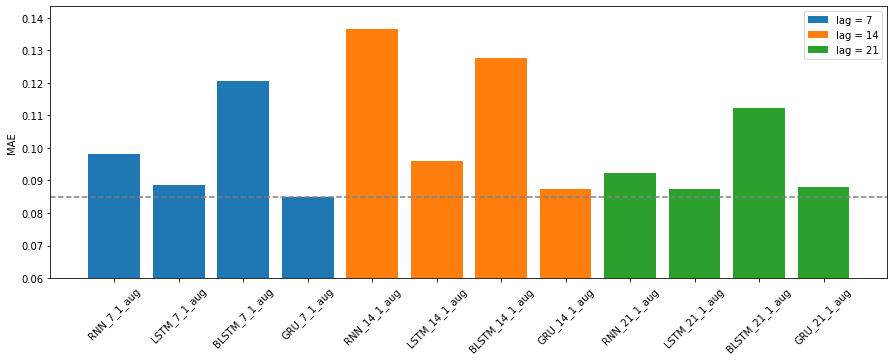

In [67]:
fig = plt.figure(figsize=(15, 5))
x = np.arange(len(results_augmented_date.MAE))
plt.bar(x[:4], results_augmented_date.MAE[results_augmented_date.Lag == 7], label="lag = 7")
plt.bar(x[4:8], results_augmented_date.MAE[results_augmented_date.Lag == 14], label="lag = 14")
plt.bar(x[8:12], results_augmented_date.MAE[results_augmented_date.Lag == 21], label="lag = 21")
plt.xticks(ticks=x, labels=results_augmented_date.Model, rotation=45)
plt.ylabel("MAE")
plt.ylim(bottom=0.06)
plt.axhline(results_augmented_date.MAE.min(), color='grey', linestyle='dashed')
plt.legend()
plt.savefig("img/ex3.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Plot the predcitions of the best model in Experiment 3 on the test set

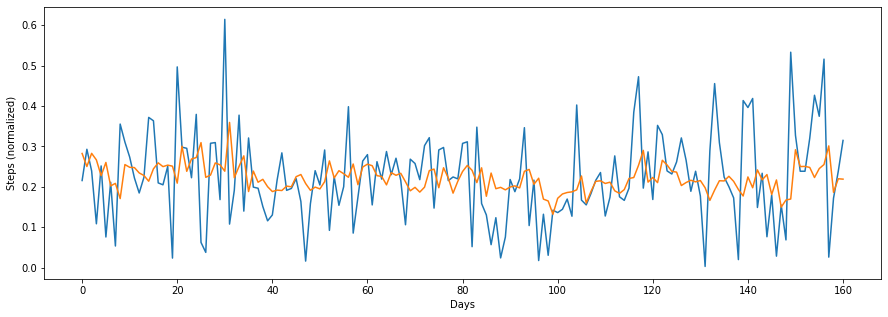

In [65]:
# Plot the prediction of the best model
model_name = results_augmented_date[results_augmented_date.MAE == results_augmented_date.MAE.min()].Model.iloc[0]

plt.figure(figsize=(15, 5))
plt.plot(aug_steps_date_models[model_name].y_test, label="True values")
plt.plot(aug_steps_date_models[model_name].predictions, label="Predictions")
#plt.title(model_name + " prediction")
plt.ylabel("Steps (normalized)")
plt.xlabel("Days")
plt.savefig("img/ex3_best_model.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

### Average MAE of the models per time lag

In [101]:
# Average MAE by time lag
results_augmented_date.groupby("Lag")['MAE'].mean()

Lag
7     0.098025
14    0.111900
21    0.095000
Name: MAE, dtype: float64

# Comparing best models 

### Select 10 best performing models + the best baseline

In [125]:
best_models = pd.concat([results_date, results_hour_to_date, results_augmented_date]).sort_values("MAE").reset_index(drop=True)[:10]
best_models.loc[10] = ["Previous Days Average", 1, preceding_average_mae, preceding_average_rmse, preceding_average_error_steps]

### Plot the MAE of the best models

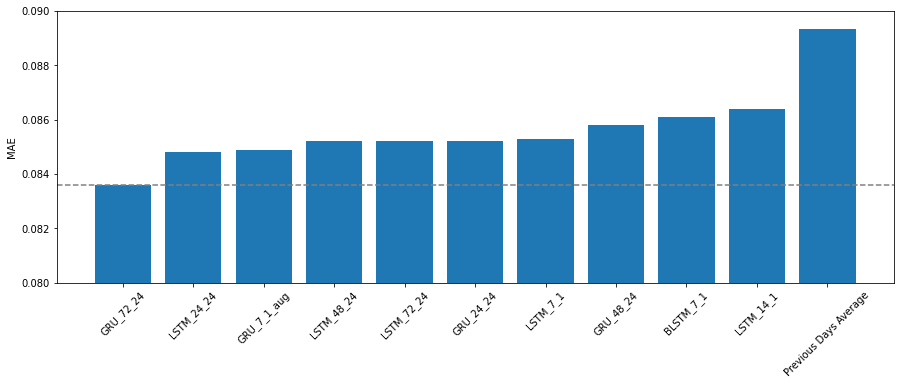

In [126]:
plt.figure(figsize=(15, 5))
x = np.arange(len(best_models))
plt.bar(x, best_models.MAE)
plt.xticks(ticks=x, labels=best_models.Model, rotation=45)
plt.axhline(best_models.MAE.min(), color='grey', linestyle='dashed')
plt.ylabel("MAE")
plt.ylim(0.08, 0.09)
plt.savefig("img/best_models.pdf", format="pdf", dpi=1200, bbox_inches = "tight")

In [127]:
best_models

,Model,Lag,MAE,RMSE,Error_Steps
0,GRU_72_24,72,0.08360,0.105400,2769
1,LSTM_24_24,24,0.08480,0.106000,2804
2,GRU_7_1_aug,7,0.08490,0.115200,2808
3,LSTM_48_24,48,0.08520,0.109400,2815
4,LSTM_72_24,72,0.08520,0.107000,2816
5,GRU_24_24,24,0.08520,0.106300,2816
6,LSTM_7_1,7,0.08530,0.113400,2820
7,GRU_48_24,48,0.08580,0.110300,2834
8,BLSTM_7_1,7,0.08610,0.115200,2844
9,LSTM_14_1,14,0.08640,0.115100,2850
